## Table of contents:
* Initial Setup
* Data Loading and Preprocessing
    * Data Variables
* Model Instantiation
* Optimizer and Scheduler
* Train and Evaluation Loop
    * Save the model and plot the losses (**1 Point**)
* Test Loop  
* Human Pose Visualization (**2 Points**)
* Report and Parameter Fine-Tuning Analysis  (**4 Points**)
* Calculating MPJPE for a Specific Frame  (**2 Points**)
* Iterative Mechanism (**3 Points**)
* YOUR custom model (**3 Points**)
    * Performance BONUS (**Up to 2 Points**)



## Initial Setup
Run the following two cellls to sync with Google Drive only if you run from Google Colab.

*Note: we recommend using Google Colab for this specific homework, since the training phase will require a GPU*

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# %cd /content/drive/MyDrive/AML/HW3/Practice

Welcome to this guide on training, testing, and fine-tuning a deep learning model. Deep learning is at the forefront of artificial intelligence, with applications spanning image recognition, natural language processing, and more.

Throughout this assignment, you'll:

1. **Prepare Data:** Preprocess and load the data.

2. **Use Neural Networks:** Instantiate a neural network architecture.

3. **Train Models:** Utilize optimization, loss functions, and backpropagation.

4. **Evaluate Performance:** Assess model performance, prevent overfitting, and underfitting.

5. **Fine-Tune Models:** Explore hyperparameter tuning.

In [1]:
from utils import h36motion3d as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.autograd
import torch
import numpy as np
from utils.loss_funcs import *
from utils.data_utils import define_actions
from utils.h36_3d_viz import visualize
import time

import torch.nn.functional as F

In [2]:
# Use GPU if available, otherwise stick with cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device,  '- Type:', torch.cuda.get_device_name(0))

Using device: cuda - Type: NVIDIA GeForce GTX 1660 Ti


## Data Loading and Preprocessing

For this homework, you will use [Human3.6M](https://vision.imar.ro/human3.6m/pami-h36m.pdf), which is a large-scale dataset of 3.6 million accurate 3D human poses acquired by recording the performance of five female and six male subjects under four different viewpoints. The dataset includes:
- Synchronized image.
- Human motion capture.
- Time of flight (depth) data.
- Accurate 3D body scans of all the subject actors involved.

The dataset aims to provide diverse motions and poses encountered in typical human activities, with additional data to train realistic human sensing systems.

![picture](https://drive.google.com/uc?export=view&id=1nyD1_F3r1ctexKFGDmhy2Q9SX_2Z_bpS)

For this assignment, we will leverage the rich **motion data** (See in the figure above) provided by H3.6M to perform a task known as *motion prediction*. Motion prediction involves using historical motion data to forecast future movements. This task is fundamental in human-robot interaction, animation, and sports analytics applications.

### Data Variables

Each created sequence has the shape (35, 17, 3), where:
- Number of observed sequences and number of sequences to predict: $N_{obs}+N_{pred} = 10 + 25 = 35$;
- Number of body joints to consider: $J=22$;
- Spatial coordinates: $(x,y,z) = 3$.


The original data provides high-resolution progressive scan videos at 50 Hz. However, the dataset has been downsampled to 25 Hz for research purposes. This means that 25 frames of motion data are provided per second.

*Note: the figure above shows 18 joints, however the dataset contains 32. For this specific case we will consider 22 joints, ignoring some of the finer ones (e.g. foot tip, hand tip, etc)*


In [ ]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)
output_n=25 # number of frames to predict on
input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22


#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

Load Dataset

*Note: It will take you ~ 5 minutes*

In [ ]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Following we create a torch dataloader that create the batches for each epoch.

In [ ]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

## Model instantiation


Each sequence comprises an **observed** part to train the Encoder and a part that attempts to predict the **future** sequence, the Decoder.

Generally, the standard setup plans to use the first 10 sequences of poses ($N_{obs}=10$) for the observation and the following 25 ($N_{pred} = 25$) for the prediction.


We create an instance of a custom Spatio-Temporal transformer with the chosen configuration.

(*Note: explore the model in ./models/sttr/sttformer.py*)

Then we allocate it to the GPU for forward and backward accelerated computation.

In [ ]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

## Optimizer and Scheduler

As we embark on training deep learning models for motion prediction using the H3.6M dataset, it's essential to recognize several key parameters and components that significantly impact the training phase:

- **Learning Rate:** This parameter determines the convergence speed during optimization.

- **Batch Size:** It influences model generalization and training efficiency.

- **Number of Epochs:** The number of training iterations affects model learning.

- **Loss Function:** The choice of loss function directly affects learning and final performance.

- **Optimizer:** The optimization algorithm used (e.g., Adam, SGD) impacts gradient descent during training.

- **Milestones and Gamma:** These parameters control learning rate schedules, allowing for adaptive adjustments during training.

- **Weight Decay:** It regulates the impact of model parameters during optimization.

- **Scheduler:** Scheduler strategies (e.g., StepLR, ReduceLROnPlateau) manage learning rate adaptation during training.

In [ ]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [ ]:
clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

## Train and Evaluation Loop

The **loss** and **metric** used during training and evaluation respectively, compare the predicted joint positions to ground truth joint positions for all frames, which is typically referred to as the **Average Mean Per
Joint Position Error (A-MPJPE)** can be seen as an $L_2$. This loss quantifies the dissimilarity between the predicted and ground truth joint positions by measuring the squared Euclidean distance between corresponding joint positions.

\begin{align*}
A-MPJPE &= \frac{1}{N_{pred}} \sum_{i=1}^{N_{pred}} \left(\frac{1}{J} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|^2\right)
\end{align*}

$$where:$$

\begin{align*}
P_{\text{predicted}} &: \text{Set of predicted joint positions estimated by the model.} \\
P_{\text{gt}} &: \text{Corresponding set of ground truth joint positions.} \\
\end{align*}

*Note: If you restart the training for any reason, remember to instantiate the model and the optimizer again. This will avoid continuing the training with the initialized weights of the previous one*


### Save the model and plot the losses (1 Point)

**Objective:** In this exercise, you will practice implementing a code snippet to save your deep learning model's checkpoints and visualize the training and validation loss on the same plot every 5 epochs during model training.

Your task is to implement the following:

- Set up a mechanism to save the model's checkpoints (weights and architecture) during training. These checkpoints should be saved periodically, say, **every 5 epochs**.

- Create a plot displaying the training and validation losses on the same graph. The x-axis should represent the number of epochs, and the y-axis should represent the loss values. The training and validation losses should be plotted as separate lines on the same graph.

- Ensure that the code saves the model's checkpoints in a specified directory, including the model's architecture and weights, and that the loss plot is displayed.

Analyze the loss plot to gain insights into how your model is learning over time and whether there are any signs of overfitting or underfitting.

*Note: see the Pytorch Documentation on how to save your model's checkpoints.*


In [12]:
def train(data_loader,vald_loader, path_to_save_model=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs-1):
      running_loss=0
      n=0
      model.train()
      for cnt,batch in enumerate(data_loader):
          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

          optimizer.zero_grad()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)


          loss=mpjpe_error(sequences_predict,sequences_gt)


          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss=0
          n=0
          for cnt,batch in enumerate(vald_loader):
              batch=batch.float().to(device)
              batch_dim=batch.shape[0]
              n+=batch_dim


              sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
              sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

              sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
              loss=mpjpe_error(sequences_predict,sequences_gt)

              if cnt % log_step == 0:
                        print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))
              running_loss+=loss*batch_dim
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n

      if use_scheduler:
        scheduler.step()

      # save and plot model every 5 epochs
      '''
      Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
      '''
      if save_and_plot and (epoch+1)%5==0 and epoch!=0: # Save the model and display the losses every 5 epochs
        torch.save(model.state_dict(), f'{path_to_save_model}/h36m_3d_25frames_ckpt_epoch_{epoch+1}.pt')

        # Plot the training and validation loss
        fig, ax = plt.subplots()
        epochs = range(1, epoch + 2, 1) # The epoch numbering in the plots starts from 1 in order to stick with the code above
        ax.plot(epochs, train_loss, 'r', label='Train loss') # Line that displays the train loss
        ax.plot(epochs, val_loss, 'g', label='Val loss') # Line that displays the validation loss
        ax.set_xticks(list(epochs))
        ax.set_xlabel('Epochs')
        ax.legend()
        plt.show()

In [ ]:
save_and_plot = True # save the model and plot the loss. Change to True if you want to save the model and plot the loss

# launch training
train(data_loader,vald_loader, path_to_save_model=model_path)

## Test Loop

After training and validation, the test loop is the final phase that evaluates the model's performance on an entirely independent dataset known as the test dataset. This dataset is distinct from the training and validation data, ensuring unbiased assessment. The test loop provides a reliable estimate of how well the model will perform in real-world scenarios, confirming that any improvements observed during training and validation are not due to overfitting or chance. It's a crucial step before deploying the model in practical applications.

In [ ]:
gt_preds = [] # Array to store tuples (ground-truth, prediction)

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cuda')))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          '''
          The code belowe has been added for the visualization task
          '''
          # Since the exercise ask to visualize 22 joints (connections found in the file at "./models/skeleton_connection.py.")
          # and the preditions already consider them, we exploit "dim_used," "index_to_ignore," and "index_to_equal" to
          # equalize the "joint to ignore" ones in the ground-truth. This allows us to plot the ground-truth and the prediction
          # together and analyze the differences.

          gt_eq_joints = sequences_gt.clone()
          gt_eq_joints[:,:,index_to_ignore] = gt_eq_joints[:,:,index_to_equal] # Equalize some nodes of the gt to plot only 22 joints out of 32
          #gt_eq_joints = gt_eq_joints[:,:,dim_used]

          gt_pred = (gt_eq_joints.view(-1, output_n, 32, 3), all_joints_seq.view(-1, output_n, 32, 3))
          gt_preds.append(tuple(gt_pred)) #Add tuples (ground-truth, prediction) to the list gt_preds
          ''''''

          loss=mpjpe_error(all_joints_seq.view(-1,output_n,32,3),sequences_gt.view(-1,output_n,32,3))
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)

*Note: Your results should be better than 95 millimiters on average*

In [ ]:
ckpt_path = './checkpoints/h36m_3d_25frames_ckpt_epoch_10.pt' # Change the epoch according to the validation curve
test(ckpt_path)

## Human Pose Visualization  (**2 Points**)

The qualitative results are as important as the quantitative ones. In this section, you will visualize and compare the predicted poses with the ground truth ones.
For simplicity, you will visualize only the first predicted pose and the ground truth.

Ideally, the same plot should show the predicted pose in red and the ground truth one in green.

*Note: you will find which nodes are connected in the file ./models/skeleton_connection.py*

In [ ]:
'''
Insert your code below
'''
def visualize_pose(gt, predict):
    # Convert tensor to numpy
    gt = gt.cpu().numpy()
    predict = predict.cpu().numpy()
    
    # Initialize the 3d plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Define connections to draw the skeleton (taken from the file ./models/skeleton_connection.py)
    connect = [
            (1, 2), (2, 3), (3, 4), (4, 5),
            (6, 7), (7, 8), (8, 9), (9, 10),
            (0, 1), (0, 6),
            (6, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22),
            (1, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
            (24, 25), (24, 17),
            (24, 14), (14, 15)
    ]

    # Plot all joints of the groud-truth (in green) and the prediction (in red)
    for i, c in enumerate(connect):
        joint1_gt = gt[c[0]]
        joint2_gt = gt[c[1]]
        joint1_pred = predict[c[0]]
        joint2_pred = predict[c[1]]
        ax.plot([joint1_gt[0], joint2_gt[0]], [joint1_gt[1], joint2_gt[1]], [joint1_gt[2], joint2_gt[2]], color='green', linewidth=2)
        ax.plot([joint1_pred[0], joint2_pred[0]], [joint1_pred[1], joint2_pred[1]], [joint1_pred[2], joint2_pred[2]], color='red', linewidth=2)

    # Set the plot limits
    xroot, yroot, zroot = gt[0]
    RADIUS = 700
    ax.set_xlim3d([-RADIUS + xroot, RADIUS + xroot])
    ax.set_zlim3d([-RADIUS + zroot, RADIUS + zroot])
    ax.set_ylim3d([-RADIUS + yroot, RADIUS + yroot])

    # Rotate the plot so that the human looks toward the camera
    ax.view_init(elev=90, azim=0, roll=90)

    # Remove the ticks axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # Set the pane color to white
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Set edge color to white
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    # Remove the grid
    ax.grid(False)
    plt.axis('off')

    # Show the plot
    plt.show()

In [ ]:
# Visualize (the first frame of) the first pose as requested by the text
first_pose = gt_preds[0]
print(first_pose[0][0][0].size())
visualize_pose(first_pose[0][0][0], first_pose[1][0][0])

## Report and Parameter Fine-Tuning Analysis  (**4 Points**)

**Objective:** In this exercise, you will analyze the results obtained from a deep learning model you previously trained and perform parameter fine-tuning to optimize its performance. The key considerations are learning rate, milestones, and weight decay. **You will also use tables and plots to visualize and interpret the outcomes.**

**Instructions:**

1. **Analysis:** Analyze the generated report and answer the following questions:
   - Is there evidence of overfitting or underfitting in the initial training results?
   - Are there fluctuations in training and validation loss or accuracy? If so, what might be causing them?
   - What can you infer from the initial learning rate, milestones, and weight decay settings?

2. **Parameter Fine-Tuning:** Based on your analysis, perform parameter fine-tuning to optimize model performance. Adjust the following parameters:
   - **Learning Rate:** Experiment with different learning rates (higher and lower values) to find an optimal rate.
   - **Milestones:** Modify the milestone values for adjusting the learning rate schedule.
   - **Weight Decay:** Explore different weight decay values.
   

3. **Re-Training:** Train the model with the adjusted hyperparameters. Record the training progress and generate a new report, including performance metrics and line plots as before.

4. **Final Analysis:** Analyze the results of the fine-tuned model and compare them with the initial training. Answer the following questions:
   - Has parameter fine-tuning improved model performance?
   - Did it mitigate overfitting or underfitting issues?
   - What can you conclude about the optimal hyperparameters for this task?


## Calculating MPJPE for a Specific Frame  (**2 Points**)


In this exercise, you will calculate the Mean Per Joint Position Error (MPJPE) for a specific frame. This skill is valuable for assessing the accuracy of your model's predictions at a particular moment.

\begin{align*}
\text{MPJPE}_t = \frac{1}{N} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|
\end{align*}

Fixed the frame $t$, you will calculate the MPJPE for the predicted pose and the ground truth. Steps:

- Write a function that takes in input the predicted pose and the ground truth one and returns the MPJPE for a number of frames $t$. (e.g. the output could be a dictionary with the frame number as key and the MPJPE as value)
- Rewrite the test function to use the function you just wrote.
- Run the newly created test function for $t=[5, 10, 15, 25]$ and report the results in a table and plot.





In [10]:
def mpjpe_per_frame(sequences_predict, sequences_gt, frames_to_consider):
    '''
    Insert your code below
    '''
    mpjpe_per_frames = {}

    for f in frames_to_consider:
      #Formula for computing the mpjpe given a prediction and the ground truth
      mpjpe_loss_per_frame = torch.norm(sequences_predict[:, f-1] - sequences_gt[:, f-1], dim=1).mean()
      #Add a key-value element in the dict where the key is the number of frame and the value is the associated loss
      mpjpe_per_frames[f] = mpjpe_loss_per_frame.item()
    
    return mpjpe_per_frames

In [11]:
#Plot the results for each frame and the average
def plot_mpjpe_results(frames_loss, avg_loss):
  frames = [str(key) for key in frames_loss.keys()]
  losses = frames_loss.values()
  plt.bar(frames, losses)
  plt.bar('avg', avg_loss)
  plt.xlabel('Frame')
  plt.ylabel('Loss')

  plt.show()

In [ ]:
def test_per_frame(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          '''
          Insert your code below.
          The function mpjpe_per_frame should return the loss for each frame in the sequence. (e.g. a dictionary with keys the frames and values the loss for each frame)
          Keep a tab of the running loss for each frame and the number of frames in the sequence.
          '''
          frames_to_consider = [5, 10, 15, 25]
          #Compute the mpjpe loss for each specified frame in the sequence
          dict_loss=mpjpe_per_frame(all_joints_seq, sequences_gt, frames_to_consider)

      '''
      Insert your code below.
      Average the loss over all the frames in the sequence and print the results.
      '''
      #Compute and print the average
      avg_loss = np.sum(list(dict_loss.values())) / len(dict_loss)
      print(f'Avg loss over all the frames in the sequence: {avg_loss}')

      #Plot the losses
      plot_mpjpe_results(dict_loss, avg_loss)


In [ ]:
'''
Insert your code below where you want to load the model and test it.
You need to specify the path to the model checkpoint file and call the test function.
'''
ckpt_path = './checkpoints/h36m_3d_25frames_ckpt_epoch_10.pt'
test_per_frame(ckpt_path)

## Iterative Mechanism (**3 Points**)

In this exercise, you will explore the concept of an iterative mechanism and its adaptability when the model's output length changes. You will start with a model designed to produce 25 output frames but adapt it to generate only 10. The exercise will involve modifying and re-training the model for the new output length. During test time, the model will generate 10 frames and then use them as input to generate the successive 10 frames, and so on, until the desired number of frames is reached. In this case, you are asked to generate 25 frames.

The steps are as follows:
- Change the model's output length from 25 to 10.
- Re-train the model.
- Rewrite the test function to generate 25 frames using the iterative mechanism.
- Generate a new report and compare the results to the baseline model.

In [3]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)

'''
Insert your code below
'''
output_n= 10

input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22

#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path_iterative= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

In [4]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...


d:\Documents\Repository\AML\homeworks + project\Homework 3\Practice\utils\h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...


In [5]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 182327
>>> Validation dataset length: 28560


In [6]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26694


In [7]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

### Train and Validation Loop

In [20]:
save_and_plot = True # save the model and plot the loss. Change to True if you want to save the model and plot the loss

[Epoch: 1, Iteration:     1]  training loss: 504.057
[Epoch: 1, Iteration:   201]  training loss: 106.718
[Epoch: 1, Iteration:   401]  training loss: 97.416
[Epoch: 1, Iteration:   601]  training loss: 79.081
[Epoch: 1, Iteration:     1]  validation loss: 70.119
[Epoch: 2, Iteration:     1]  training loss: 78.658
[Epoch: 2, Iteration:   201]  training loss: 72.632
[Epoch: 2, Iteration:   401]  training loss: 72.550
[Epoch: 2, Iteration:   601]  training loss: 67.082
[Epoch: 2, Iteration:     1]  validation loss: 60.884
[Epoch: 3, Iteration:     1]  training loss: 70.515
[Epoch: 3, Iteration:   201]  training loss: 64.529
[Epoch: 3, Iteration:   401]  training loss: 67.081
[Epoch: 3, Iteration:   601]  training loss: 65.555
[Epoch: 3, Iteration:     1]  validation loss: 59.960
[Epoch: 4, Iteration:     1]  training loss: 65.540
[Epoch: 4, Iteration:   201]  training loss: 65.584
[Epoch: 4, Iteration:   401]  training loss: 66.870
[Epoch: 4, Iteration:   601]  training loss: 66.410
[Epo

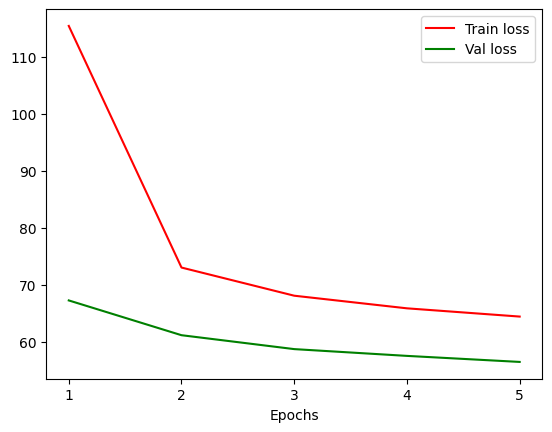

[Epoch: 6, Iteration:     1]  training loss: 65.822
[Epoch: 6, Iteration:   201]  training loss: 61.157
[Epoch: 6, Iteration:   401]  training loss: 62.243
[Epoch: 6, Iteration:   601]  training loss: 61.069
[Epoch: 6, Iteration:     1]  validation loss: 56.312
[Epoch: 7, Iteration:     1]  training loss: 63.022
[Epoch: 7, Iteration:   201]  training loss: 62.551
[Epoch: 7, Iteration:   401]  training loss: 64.153
[Epoch: 7, Iteration:   601]  training loss: 63.844
[Epoch: 7, Iteration:     1]  validation loss: 56.064
[Epoch: 8, Iteration:     1]  training loss: 60.456
[Epoch: 8, Iteration:   201]  training loss: 63.199
[Epoch: 8, Iteration:   401]  training loss: 64.682
[Epoch: 8, Iteration:   601]  training loss: 62.170
[Epoch: 8, Iteration:     1]  validation loss: 55.617
[Epoch: 9, Iteration:     1]  training loss: 59.983
[Epoch: 9, Iteration:   201]  training loss: 58.037
[Epoch: 9, Iteration:   401]  training loss: 60.365
[Epoch: 9, Iteration:   601]  training loss: 58.929
[Epoch

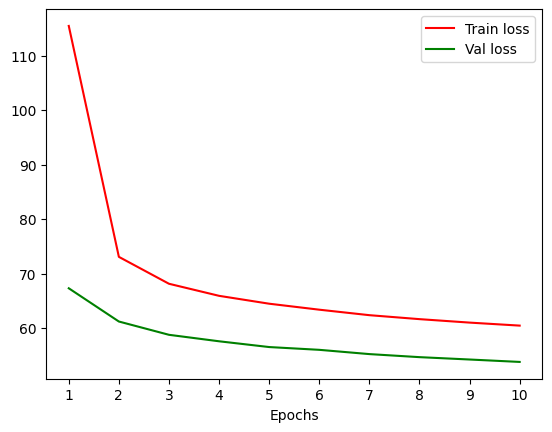

[Epoch: 11, Iteration:     1]  training loss: 60.417
[Epoch: 11, Iteration:   201]  training loss: 59.635
[Epoch: 11, Iteration:   401]  training loss: 58.446
[Epoch: 11, Iteration:   601]  training loss: 58.308
[Epoch: 11, Iteration:     1]  validation loss: 54.262
[Epoch: 12, Iteration:     1]  training loss: 58.326
[Epoch: 12, Iteration:   201]  training loss: 61.891
[Epoch: 12, Iteration:   401]  training loss: 59.768
[Epoch: 12, Iteration:   601]  training loss: 61.445
[Epoch: 12, Iteration:     1]  validation loss: 53.460
[Epoch: 13, Iteration:     1]  training loss: 54.769
[Epoch: 13, Iteration:   201]  training loss: 61.309
[Epoch: 13, Iteration:   401]  training loss: 58.232
[Epoch: 13, Iteration:   601]  training loss: 56.027
[Epoch: 13, Iteration:     1]  validation loss: 52.754
[Epoch: 14, Iteration:     1]  training loss: 59.650
[Epoch: 14, Iteration:   201]  training loss: 57.970
[Epoch: 14, Iteration:   401]  training loss: 58.661
[Epoch: 14, Iteration:   601]  training 

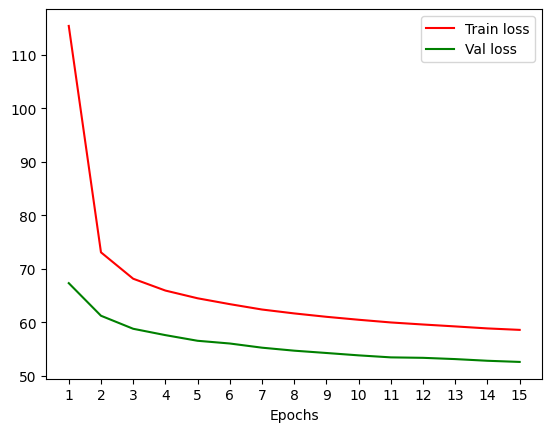

[Epoch: 16, Iteration:     1]  training loss: 57.000
[Epoch: 16, Iteration:   201]  training loss: 56.687
[Epoch: 16, Iteration:   401]  training loss: 56.851
[Epoch: 16, Iteration:   601]  training loss: 60.273
[Epoch: 16, Iteration:     1]  validation loss: 55.472
[Epoch: 17, Iteration:     1]  training loss: 60.238
[Epoch: 17, Iteration:   201]  training loss: 57.319
[Epoch: 17, Iteration:   401]  training loss: 57.639
[Epoch: 17, Iteration:   601]  training loss: 58.766
[Epoch: 17, Iteration:     1]  validation loss: 50.997
[Epoch: 18, Iteration:     1]  training loss: 57.288
[Epoch: 18, Iteration:   201]  training loss: 61.295
[Epoch: 18, Iteration:   401]  training loss: 56.396
[Epoch: 18, Iteration:   601]  training loss: 59.762
[Epoch: 18, Iteration:     1]  validation loss: 51.373
[Epoch: 19, Iteration:     1]  training loss: 58.077
[Epoch: 19, Iteration:   201]  training loss: 57.056
[Epoch: 19, Iteration:   401]  training loss: 54.930
[Epoch: 19, Iteration:   601]  training 

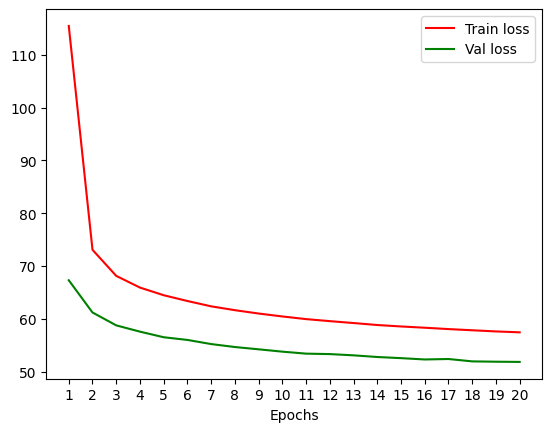

[Epoch: 21, Iteration:     1]  training loss: 54.425
[Epoch: 21, Iteration:   201]  training loss: 57.712
[Epoch: 21, Iteration:   401]  training loss: 55.825
[Epoch: 21, Iteration:   601]  training loss: 58.690
[Epoch: 21, Iteration:     1]  validation loss: 52.615
[Epoch: 22, Iteration:     1]  training loss: 55.625
[Epoch: 22, Iteration:   201]  training loss: 56.452
[Epoch: 22, Iteration:   401]  training loss: 56.422
[Epoch: 22, Iteration:   601]  training loss: 60.253
[Epoch: 22, Iteration:     1]  validation loss: 52.545
[Epoch: 23, Iteration:     1]  training loss: 55.435
[Epoch: 23, Iteration:   201]  training loss: 55.337
[Epoch: 23, Iteration:   401]  training loss: 57.329
[Epoch: 23, Iteration:   601]  training loss: 56.694
[Epoch: 23, Iteration:     1]  validation loss: 51.761
[Epoch: 24, Iteration:     1]  training loss: 54.495
[Epoch: 24, Iteration:   201]  training loss: 56.174
[Epoch: 24, Iteration:   401]  training loss: 55.260
[Epoch: 24, Iteration:   601]  training 

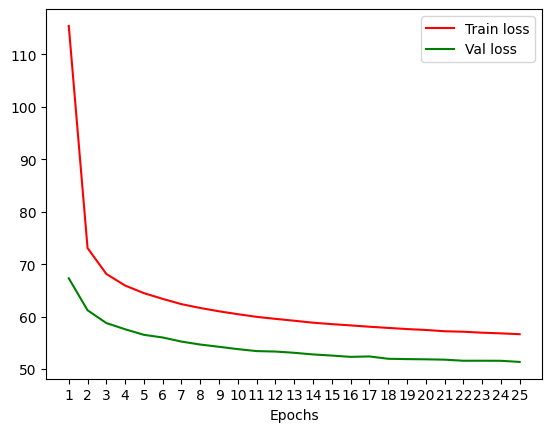

[Epoch: 26, Iteration:     1]  training loss: 57.497
[Epoch: 26, Iteration:   201]  training loss: 55.650
[Epoch: 26, Iteration:   401]  training loss: 53.251
[Epoch: 26, Iteration:   601]  training loss: 57.628
[Epoch: 26, Iteration:     1]  validation loss: 52.050
[Epoch: 27, Iteration:     1]  training loss: 56.483
[Epoch: 27, Iteration:   201]  training loss: 59.634
[Epoch: 27, Iteration:   401]  training loss: 55.895
[Epoch: 27, Iteration:   601]  training loss: 53.683
[Epoch: 27, Iteration:     1]  validation loss: 49.849
[Epoch: 28, Iteration:     1]  training loss: 58.208
[Epoch: 28, Iteration:   201]  training loss: 55.448
[Epoch: 28, Iteration:   401]  training loss: 57.151
[Epoch: 28, Iteration:   601]  training loss: 56.493
[Epoch: 28, Iteration:     1]  validation loss: 49.976
[Epoch: 29, Iteration:     1]  training loss: 58.319
[Epoch: 29, Iteration:   201]  training loss: 55.714
[Epoch: 29, Iteration:   401]  training loss: 54.008
[Epoch: 29, Iteration:   601]  training 

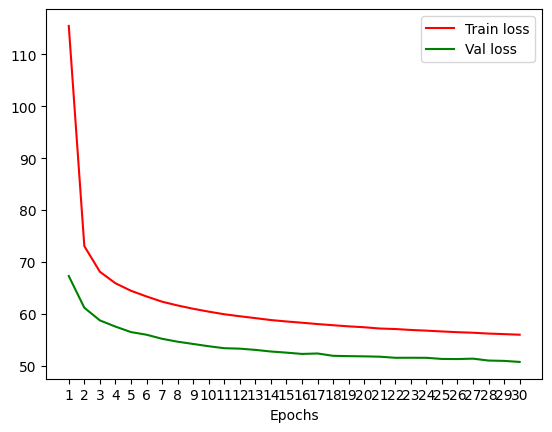

[Epoch: 31, Iteration:     1]  training loss: 56.710
[Epoch: 31, Iteration:   201]  training loss: 54.099
[Epoch: 31, Iteration:   401]  training loss: 55.403
[Epoch: 31, Iteration:   601]  training loss: 56.747
[Epoch: 31, Iteration:     1]  validation loss: 50.361
[Epoch: 32, Iteration:     1]  training loss: 56.124
[Epoch: 32, Iteration:   201]  training loss: 57.778
[Epoch: 32, Iteration:   401]  training loss: 53.983
[Epoch: 32, Iteration:   601]  training loss: 57.727
[Epoch: 32, Iteration:     1]  validation loss: 50.135
[Epoch: 33, Iteration:     1]  training loss: 55.474
[Epoch: 33, Iteration:   201]  training loss: 54.340
[Epoch: 33, Iteration:   401]  training loss: 54.071
[Epoch: 33, Iteration:   601]  training loss: 53.223
[Epoch: 33, Iteration:     1]  validation loss: 51.339
[Epoch: 34, Iteration:     1]  training loss: 53.660
[Epoch: 34, Iteration:   201]  training loss: 55.824
[Epoch: 34, Iteration:   401]  training loss: 55.303
[Epoch: 34, Iteration:   601]  training 

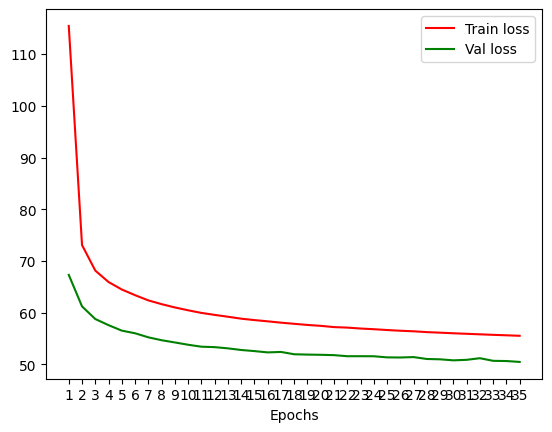

[Epoch: 36, Iteration:     1]  training loss: 56.012
[Epoch: 36, Iteration:   201]  training loss: 59.940
[Epoch: 36, Iteration:   401]  training loss: 57.874
[Epoch: 36, Iteration:   601]  training loss: 55.788
[Epoch: 36, Iteration:     1]  validation loss: 51.511
[Epoch: 37, Iteration:     1]  training loss: 56.441
[Epoch: 37, Iteration:   201]  training loss: 54.875
[Epoch: 37, Iteration:   401]  training loss: 53.976
[Epoch: 37, Iteration:   601]  training loss: 51.998
[Epoch: 37, Iteration:     1]  validation loss: 50.254
[Epoch: 38, Iteration:     1]  training loss: 56.615
[Epoch: 38, Iteration:   201]  training loss: 55.626
[Epoch: 38, Iteration:   401]  training loss: 55.222
[Epoch: 38, Iteration:   601]  training loss: 53.351
[Epoch: 38, Iteration:     1]  validation loss: 49.829
[Epoch: 39, Iteration:     1]  training loss: 55.066
[Epoch: 39, Iteration:   201]  training loss: 51.914
[Epoch: 39, Iteration:   401]  training loss: 54.330
[Epoch: 39, Iteration:   601]  training 

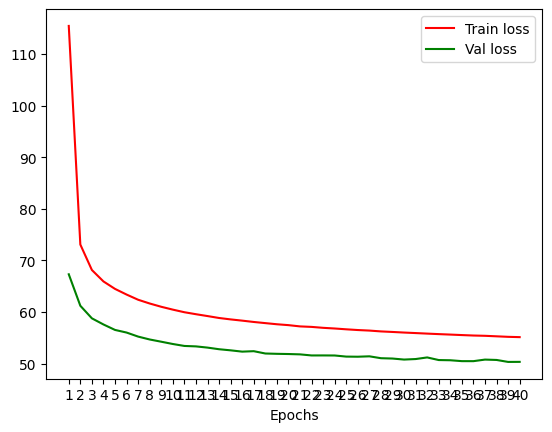

In [21]:
# launch training with the new output_n
train(data_loader,vald_loader, path_to_save_model=model_path_iterative)

### Test Loop

In [22]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0

      FINAL_SEQUENCE_LENGTH = 25

      dataset_test = datasets.Datasets(path,input_n,FINAL_SEQUENCE_LENGTH,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))
      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)

      for cnt, batch in enumerate(test_loader):
        final_predicted_sequence = None
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim
          
          # ground truth and the final sequence length should be 25, even if the output of the model is 10.
          all_joints_seq=batch.clone()[:, input_n:input_n+FINAL_SEQUENCE_LENGTH,:]
          sequences_gt = batch[:, input_n:input_n+FINAL_SEQUENCE_LENGTH, :]

          running_time = time.time()
          '''
          Insert your code below. You will need to iteratively predict the next frames and feed it to back to the model until you reach the desired number of frames.
          '''
          # Getting the current sequence from the batch (length 10)
          sequences_predict = batch[:, 0:input_n, dim_used]
          # Until I get the desired sequence length
          while final_predicted_sequence is None or final_predicted_sequence.shape[1] < FINAL_SEQUENCE_LENGTH:
            # I reshape the sequence to feed it to the model
            sequences_predict = sequences_predict.view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
            sequences_predict = model(sequences_predict)

            # I keep another copy of the sequence reshaped in another way in order to concatenate it to the final sequence
            reshaped_sequences_predict = sequences_predict.view(-1, output_n, joints_to_consider, 3)


            if final_predicted_sequence is None:
              # If the final sequence is empty, I just assign the first sequence predicted
              final_predicted_sequence = reshaped_sequences_predict
            else:
              # Otherwise I concatenate the new sequence to the final one, checking that the final sequence length is not greater than 25
              if (final_predicted_sequence.shape[1] + sequences_predict.shape[1] > FINAL_SEQUENCE_LENGTH):
                reshaped_sequences_predict = reshaped_sequences_predict[:, :reshaped_sequences_predict.shape[1] + output_n - FINAL_SEQUENCE_LENGTH, :, :]
              final_predicted_sequence = torch.cat((final_predicted_sequence, reshaped_sequences_predict), dim=1)
        
            totalll += time.time()-running_time
            counter += 1
          
          # Trick to get represent the final sequence in the same way as the ground truth (32 joints instead of 22)
          all_joints_seq[:,:,dim_used] = final_predicted_sequence.contiguous().view(-1,FINAL_SEQUENCE_LENGTH,len(dim_used))
          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          all_joints_seq = all_joints_seq.view(-1, FINAL_SEQUENCE_LENGTH, 32, 3)
          sequences_gt = sequences_gt.view(-1, FINAL_SEQUENCE_LENGTH, 32, 3)
        
          loss = mpjpe_error(all_joints_seq,sequences_gt)
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)


In [23]:
import os
latest_model_path = os.path.join(model_path_iterative, sorted(os.listdir(model_path_iterative))[-1])
test(ckpt_path=latest_model_path)

model loaded


d:\Documents\Repository\AML\homeworks + project\Homework 3\Practice\utils\h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking :  91.2
eating :  72.2
smoking :  73.1
discussion :  94.2
directions :  85.8
greeting :  109.6
phoning :  86.8
posing :  122.7
purchases :  106.7
sitting :  94.5
sittingdown :  127.4
takingphoto :  94.6
waiting :  93.8
walkingdog :  119.3
walkingtogether :  78.2
Average: 96.7
Prediction time:  0.016961735652552712


In [ ]:
# Standard model:
#     walking :  61.8
#     eating :  59.2
#     smoking :  59.6
#     discussion :  86.6
#     directions :  77.8
#     greeting :  101.3
#     phoning :  76.2
#     posing :  115.9
#     purchases :  101.8
#     sitting :  87.7
#     sittingdown :  111.4
#     takingphoto :  85.8
#     waiting :  80.9
#     walkingdog :  109.4
#     walkingtogether :  58.3
#     Average: 84.9
#     Prediction time:  0.008855208257834117
# Iterative Model (sequence length=30):
#     walking :  81.5
#     eating :  69.7
#     smoking :  69.7
#     discussion :  94.9
#     directions :  84.4
#     greeting :  110.9
#     phoning :  85.1
#     posing :  125.0
#     purchases :  109.8
#     sitting :  94.7
#     sittingdown :  122.5
#     takingphoto :  92.6
#     waiting :  89.7
#     walkingdog :  123.4
#     walkingtogether :  73.9
#     Average: 95.2
#     Prediction time:  0.014884731339083777

# Iterative Model (sequence length=25):
    # walking :  74.8
    # eating :  63.2
    # smoking :  63.2
    # discussion :  87.8
    # directions :  77.2
    # greeting :  103.1
    # phoning :  76.3
    # posing :  112.0
    # purchases :  100.9
    # sitting :  85.4
    # sittingdown :  111.8
    # takingphoto :  83.1
    # waiting :  82.0
    # walkingdog :  114.2
    # walkingtogether :  67.1
    # Average: 86.8
    # Prediction time:  0.016014835238456725

## YOUR custom model (**3 Points**)
 In this exercise, you will implement a Transformer-like network (based on the Theory notebook) for this specific task. You can use the Transformer's Encoder and implement your own Decoder to predict future poses. (e.g. RNN, MLP, CNN, TCN, ...).
 We won't provide any code for this exercise, but you can use the code provided in the Theory notebook as a starting point.
 The goal of this exercise is not to beat the previous model but to understand how to implement a Transformer network for this specific task. For this reason, the evaluation will be based on the code you write and the explanation you provide in the report rather than the results.


### Performance BONUS (**Up to 2 Points**)
- **1 Bonus Point** if the model achieves an A-MPJPE between 80 and 90 millimeters.
- **2 Bonus Points** if the model achieves an A-MPJPE between 70 and 80 millimeters.


In [ ]:
'''
Input Shape: [batch_size, input_time, joints, 3]

Encoder:
Input shape: [batch_size, input_time, joints, 3]
Output shape: [batch_size, input_time/output_time, joints, FREE]

# Decoder:
Input shape: [batch_size, input_time/output_time, joints, FREE]
Output shape: [batch_size, output_time, joints, 3]


Hint: Transformers often take an input of shape [batch_size, time, joints*channels], use the reshape or view function to match the dimensionality.
'''

In [29]:
import torch
import torch.nn as nn
from copy import deepcopy

In [24]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)

'''
Insert your code below
'''
output_n= 10

input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22

#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path_iterative= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

In [25]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...
Loading Validation Dataset...


In [26]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 182327
>>> Validation dataset length: 28560


In [27]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26694


In [31]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super(MultiheadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.dropout = nn.Dropout(dropout)
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        q = self.q_linear(query)
        k = self.k_linear(key)
        v = self.v_linear(value)
        q = q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout(scores)
        attended = torch.matmul(scores, v)
        attended = attended.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.out_linear(attended)
        return out

In [30]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout):
        super(EncoderBlock, self).__init__()
        self.self_attn = MultiheadAttention(d_model, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
    
    def forward(self, src, src_mask):
        src2 = self.self_attn(src, src, src, src_mask)
        src = src + self.dropout(src2)
        src = self.norm1(src)
        src2 = self.feed_forward(src)
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src

In [32]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout):
        super(DecoderBlock, self).__init__()
        self.self_attn = MultiheadAttention(d_model, num_heads, dropout)
        self.enc_dec_attn = MultiheadAttention(d_model, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
    
    def forward(self, trg, memory, trg_mask, memory_mask):
        trg2 = self.self_attn(trg, trg, trg, trg_mask)
        trg = trg + self.dropout(trg2)
        trg = self.norm1(trg)
        trg2 = self.enc_dec_attn(trg, memory, memory, memory_mask)
        trg = trg + self.dropout(trg2)
        trg = self.norm2(trg)
        trg2 = self.feed_forward(trg)
        trg = trg + self.dropout(trg2)
        trg = self.norm3(trg)
        return trg

In [33]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [36]:
class Transformer(nn.Module):
    def __init__(self, enc_inp_size, dec_inp_size, dec_out_size, N=6, d_model=512, dim_feedforward=2048, num_heads=8, dropout=0.1, mean=[0,0],std=[0,0]):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.N = N
        self.mean = mean
        self.std = std
        self.enc_inp_size = enc_inp_size
        self.dec_inp_size = dec_inp_size
        self.dec_out_size = dec_out_size
        self.encoder = nn.ModuleList([deepcopy(EncoderBlock(d_model, num_heads, dim_feedforward, dropout)) for _ in range(N)])
        self.decoder = nn.ModuleList([deepcopy(DecoderBlock(d_model, num_heads, dim_feedforward, dropout)) for _ in range(N)])
        self.pos_enc = PositionalEncoding(d_model, dropout)
        self.pos_dec = PositionalEncoding(d_model, dropout)
        self.src_embed = nn.Linear(enc_inp_size, d_model)
        self.tgt_embed = nn.Linear(dec_inp_size, d_model)
        self.out = nn.Linear(d_model, dec_out_size)
        self.init_weights()

    def forward(self, src, trg, src_mask, trg_mask):
        # First part of the forward pass: embedding and positional encoding
        src = self.pos_enc(self.src_embed(src))
        trg = self.pos_dec(self.tgt_embed(trg))

        # Second part of the forward pass: the encoder and decoder layers
        for i in range(self.N):
            src = self.encoder[i](src, src_mask)
            trg = self.decoder[i](trg, src, trg_mask)

        # Final linear layer for output
        output = self.out(trg)
        return output

    def reshape_input(data):
        # Reshape the input data to match the Transformer's input shape
        batch_size, input_time, joints, _ = data.shape
        return data.reshape(batch_size, input_time, joints * 3)

In [37]:
# Create the input and output data for training and testing
input_data = torch.randn(batch_size, input_time, joints, 3)
output_data = torch.randn(batch_size, output_time, joints, 3)

NameError: name 'input_time' is not defined

In [ ]:
# Initialize the Transformer model
model = Transformer(enc_inp_size, dec_inp_size, dec_out_size)

In [ ]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(input_data, output_data, src_mask, trg_mask)
    loss = criterion(outputs, output_data)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Test the model
with torch.no_grad():
    outputs = model(input_data, output_data, src_mask, trg_mask)
    loss = criterion(outputs, output_data)
    print(f'Test Loss: {loss.item():.4f}')

In [ ]:
# Perform motion prediction using the trained model
prediction = model(input_data, output_data, src_mask, trg_mask)